## Multiple time series: TBA

## Multivariate time series: TBA


## Global Forecasting Models
Darts contains many forecasting models, but not all of them can be trained on several time series. The models that support training on multiple series are called global models. These are:

* BlockRNNModel
* RNNModel
* Temporal Convolutional Networks (TCNs)
* N-Beats
* Transformer model

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)
freq='2H3T14S'

In [2]:
def load_dataset(training_file, testing_file):
    dataframes = []
    for data_file in [training_file, testing_file]:
        parser = lambda data_string: datetime.strptime(data_string, '%Y-%m-%d %H:%M:%S')
#         dataframe = pd.read_csv(data_file)
        dataframe = pd.read_csv(data_file, parse_dates=['Time'],
                                date_parser=parser)
        print(f"Rows in {data_file}: {len(dataframe)}")
        dataframe.drop(['Ls', 'LT', 'CO2ice'], axis=1, inplace=True)
#         dataframe.index.name = "Time"

        # if data_file == training_file:
        #     dataframe[TRAINING_FLAG_COLUMN] = True
        # elif data_file == testing_file:
        #     dataframe[TRAINING_FLAG_COLUMN] = False

        dataframes.append(dataframe)

    return pd.concat(dataframes, axis=0)

In [3]:
dataframe = load_dataset('../data/data_files/insight_openmars_training_time.csv',
                         '../data/data_files/insight_openmars_test_time.csv')
dataframe.head()

Rows in ../data/data_files/insight_openmars_training_time.csv: 72196
Rows in ../data/data_files/insight_openmars_test_time.csv: 16364


,Time,Tsurf,Psurf,cloud,vapour,u_wind,v_wind,dust,temp
0,1998-07-15 21:23:39,264.042,721.113,0.092,0.027,-7.451,8.604,0.428,179.686
1,1998-07-15 23:26:53,274.736,705.090,0.145,0.026,-7.053,4.934,0.427,174.502
2,1998-07-16 01:30:07,265.939,700.691,0.105,0.026,-6.825,-0.063,0.427,173.429
3,1998-07-16 03:33:21,238.624,697.252,0.134,0.025,-5.373,-4.048,0.426,173.556
4,1998-07-16 05:36:35,213.634,717.146,0.139,0.026,-3.899,-3.133,0.426,174.789


In [4]:
# Calculating a custom datarange index as the frequencies in observed data are irregular
time = pd.date_range("1998-07-15 21:23:39", periods=len(dataframe), freq=freq)
time

DatetimeIndex(['1998-07-15 21:23:39', '1998-07-15 23:26:53',
               '1998-07-16 01:30:07', '1998-07-16 03:33:21',
               '1998-07-16 05:36:35', '1998-07-16 07:39:49',
               '1998-07-16 09:43:03', '1998-07-16 11:46:17',
               '1998-07-16 13:49:31', '1998-07-16 15:52:45',
               ...
               '2019-04-14 21:15:19', '2019-04-14 23:18:33',
               '2019-04-15 01:21:47', '2019-04-15 03:25:01',
               '2019-04-15 05:28:15', '2019-04-15 07:31:29',
               '2019-04-15 09:34:43', '2019-04-15 11:37:57',
               '2019-04-15 13:41:11', '2019-04-15 15:44:25'],
              dtype='datetime64[ns]', length=88560, freq='7394S')

In [5]:
dataframe.index = time
dataframe = dataframe.drop(['Time'], axis=1)
dataframe.head()

,Tsurf,Psurf,cloud,vapour,u_wind,v_wind,dust,temp
1998-07-15 21:23:39,264.042,721.113,0.092,0.027,-7.451,8.604,0.428,179.686
1998-07-15 23:26:53,274.736,705.090,0.145,0.026,-7.053,4.934,0.427,174.502
1998-07-16 01:30:07,265.939,700.691,0.105,0.026,-6.825,-0.063,0.427,173.429
1998-07-16 03:33:21,238.624,697.252,0.134,0.025,-5.373,-4.048,0.426,173.556
1998-07-16 05:36:35,213.634,717.146,0.139,0.026,-3.899,-3.133,0.426,174.789


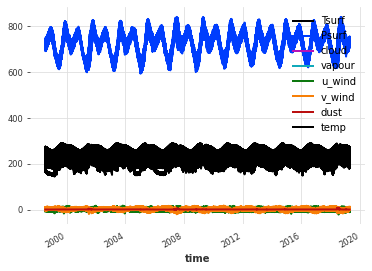

In [6]:
series = TimeSeries.from_dataframe(dataframe, time_col=None, value_cols=None, fill_missing_dates=True, freq='7394S', fillna_value=None)
series.plot()

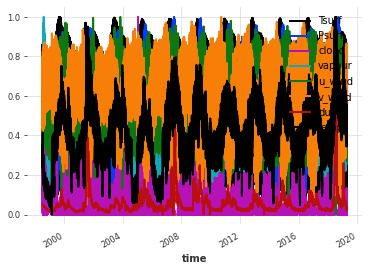

In [7]:
scaler = Scaler()
series_scaled = scaler.fit_transform(series)
series_scaled.plot()

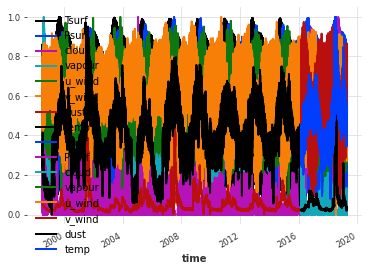

In [8]:
train_series, val_series = series_scaled.split_before(0.85)
train_series.plot()
val_series.plot()

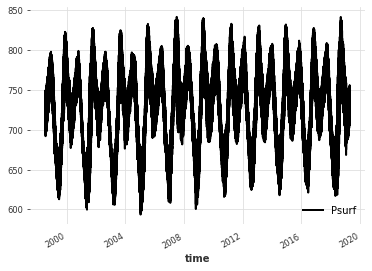

In [9]:
df_covF = dataframe.loc[:, dataframe.columns != "Psurf"]
series_covF = TimeSeries.from_dataframe(df_covF)

df_Psurf = dataframe.loc[:, dataframe.columns == "Psurf"]
series_Psurf = TimeSeries.from_dataframe(df_Psurf)
series_Psurf.plot()



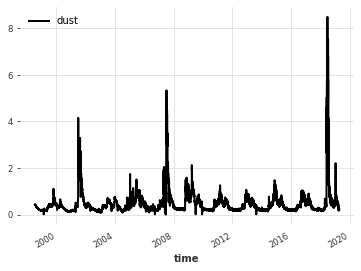

In [24]:
df_dust = dataframe.loc[:, dataframe.columns == "dust"]
series_dust = TimeSeries.from_dataframe(df_dust)
series_dust.plot()

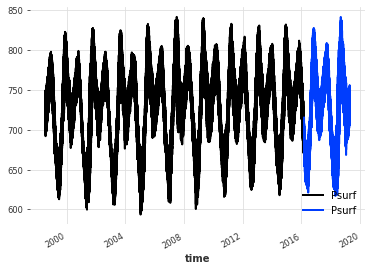

In [10]:
train_series_Psurf, val_series_Psurf = series_Psurf.split_before(0.85)
train_series_Psurf.plot()
val_series_Psurf.plot()


In the following, we will distinguish two sorts of time series:

* The **target time** series is the time series we are interested to forecast (given its history).
* A **covariate time series** is a time series which may help in the forecasting of the target series, but that we are not interested in forecasting. It's sometimes also called **external data**.

We further differentiate covariates series, depending on whether they can be known in advance or not:

* **Past Covariates** denote time series whose past values are known at prediction time. These are usually things that have to be measured or observed.
* **Future Covariates** denote time series whose future values are already known at prediction time for the span of the forecast horizon. These can for instance represent known future holidays, or weather forecasts.

Some models use only past covariates, others use only future covariates, and some models might use both. We will dive deeper in this topic in some other notebook, but for now it is enough to know this:

* BlockRNNModel, TCNModel, NBEATSModel and TransformerModel all use past_covariates.
* RNNModel uses future_covariates.

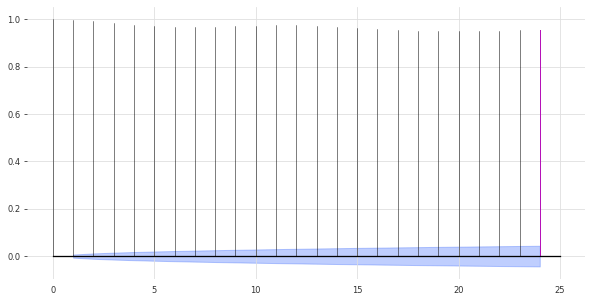

In [28]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(series_dust, m=2*12, alpha=0.05)

In [29]:

# check for seasonality, via ACF
MSEAS = 24                    # seasonality default
ALPHA = 0.05 
for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(series_Psurf, m=m, alpha=ALPHA)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {}.'.format(mseas))

seasonal? True
There is seasonality of order 12.


In [31]:
model_psurf = NBEATSModel(
    input_chunk_length=24, output_chunk_length=12, n_epochs=20, random_state=0
)

In [32]:
model_psurf.fit(train_series_Psurf, verbose=True)


[2022-07-28 17:22:05,155] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 75240 samples.
[2022-07-28 17:22:05,155] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 75240 samples.
2022-07-28 17:22:05 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 75240 samples.
[2022-07-28 17:22:05,463] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-07-28 17:22:05,463] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-07-28 17:22:05 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
[2022-07-28 17:22:05,465] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Li

Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Predicting: 2352it [00:00, ?it/s]

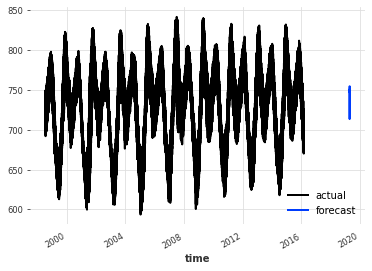

In [33]:
pred = model_psurf.predict(n=12, series = val_series_Psurf)

train_series_Psurf.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
# print("MAPE = {:.2f}%".format(mape(val_series_Psurf, pred)))